In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read survey
data_dictionary = pd.read_csv('data_dictionary.csv')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# read aggregated actigraphy
actigraphy_data = pd.read_csv('PA_data.csv', index_col=0)

In [3]:
# Outliers ----------------------------------------------------------------------------
# removing outliers (should change this to be automatic so it applies to the test data)
# From CGAS
train_data.loc[2065, 'CGAS-CGAS_Score'] = 99
# From BIA (there might still be some suspicious extreme values)
cols = data_dictionary.loc[(data_dictionary['Instrument'] == 'Bio-electric Impedance Analysis') & (data_dictionary['Type'] == 'float'), 'Field']
train_data.loc[[3205, 3511], cols] = np.nan # remove 3511 and 3205's BIA values because they seem wrong. They have normal heights and weights but extreme values for BIA measures

# Drop features ----------------------------------------------------------------------
# combine FitnessGram Minutes and seconds
train_data['Fitness_Endurance-Total_Time_sec'] = train_data['Fitness_Endurance-Time_Mins'] * 60 + train_data['Fitness_Endurance-Time_Sec'] # remove remaining Fitness_Endurance Columns
# drop all PCIAT columns, any column that ends in -Season, FitnessGram Zones, remaining Fitness_Endurance columns, and redundant SDS column
columns_to_drop = [col for col in train_data.columns if col.startswith('PCIAT') or col.endswith('Season') or col.endswith('Zone')]
columns_to_drop.extend(['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Sec', 'Fitness_Endurance-Time_Mins', 'SDS-SDS_Total_Raw'])
train_data_cleaned = train_data.drop(columns=columns_to_drop)

# merge PAQ_A and PAQ_C
# keep adolescent value if 13 or older
train_data_cleaned.loc[train_data_cleaned['PAQ_A-PAQ_A_Total'].notna() & train_data_cleaned['PAQ_C-PAQ_C_Total'].notna() & (train_data_cleaned['Basic_Demos-Age'] >= 13), 'PAQ_C-PAQ_C_Total'] = np.nan
# keep child value is younger than 13
train_data_cleaned.loc[train_data_cleaned['PAQ_A-PAQ_A_Total'].notna() & train_data_cleaned['PAQ_C-PAQ_C_Total'].notna() & (train_data_cleaned['Basic_Demos-Age'] < 13), 'PAQ_A-PAQ_A_Total'] = np.nan
# merge columns
train_data_cleaned['PAQ-PAQ_Total'] = train_data_cleaned['PAQ_A-PAQ_A_Total'].fillna(train_data_cleaned['PAQ_C-PAQ_C_Total'])
# drop columns
train_data_cleaned = train_data_cleaned.drop(columns = ['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total'])

# include aggregate acitgraphy features
train_data_cleaned = pd.merge(train_data_cleaned, actigraphy_data, left_on='id', how='left', right_index=True)

# Missing Values (might not have to handle completely manually for CATBoost, though it could improve performance) -----------
# Drop rows with high missingness (should investigate characteristics of rows with high missingness)
thresh = 50
percent_missing_per_row = train_data_cleaned.isnull().mean(axis=1) * 100
high_missingness_idx = percent_missing_per_row[percent_missing_per_row > thresh].index.values
train_data_cleaned = train_data_cleaned.drop(high_missingness_idx)
print(f'{len(high_missingness_idx)} rows dropped because {thresh}% or more of the data was missing.')
print(f'There are {len(train_data_cleaned)} rows remaining in the train data.')

# Drop features with high missingness?
print('This is the proportion of data available per feature. It might be wise to drop features with high missingness. We can try both ways though.')
display(train_data_cleaned.notna().mean().sort_values())

# Impute/interpolate remaining missing values (not necessary for CATBoost)

# Convert categorical columns to the correct data type? Since their ordinal, it might work to not convert
# use data dictionary to convert features that have type=="categorical int" into str dtype

# drop rows without target
train_data_cleaned = train_data_cleaned.dropna(subset='sii')
print(f'Final length of the training dataset: {len(train_data_cleaned)}')

1863 rows dropped because 50% or more of the data was missing.
There are 2097 rows remaining in the train data.
This is the proportion of data available per feature. It might be wise to drop features with high missingness. We can try both ways though.


Physical-Waist_Circumference              0.249881
Fitness_Endurance-Total_Time_sec          0.311874
vigorous                                  0.384835
moderate                                  0.395327
light                                     0.395804
sendentary                                0.395804
FGC-FGC_GSND                              0.405341
FGC-FGC_GSD                               0.405818
PAQ-PAQ_Total                             0.646161
CGAS-CGAS_Score                           0.820219
SDS-SDS_Total_T                           0.842632
FGC-FGC_PU                                0.855508
FGC-FGC_SRL                               0.855508
FGC-FGC_SRR                               0.856462
FGC-FGC_CU                                0.859323
FGC-FGC_TL                                0.859800
sii                                       0.919409
BIA-BIA_SMM                               0.944206
BIA-BIA_LST                               0.944206
BIA-BIA_LDM                    

Final length of the training dataset: 1928


Regression Model Performance:
Mean Squared Error (MSE): 0.5285
Root Mean Squared Error (RMSE): 0.7270
Mean Absolute Error (MAE): 0.5420
R² Score: 0.1236


c:\Users\shaun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:11:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Model Performance:
Accuracy: 0.5933

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       228
           1       0.37      0.28      0.32       105
           2       0.40      0.36      0.38        45
           3       0.33      0.12      0.18         8

    accuracy                           0.59       386
   macro avg       0.45      0.39      0.40       386
weighted avg       0.56      0.59      0.57       386



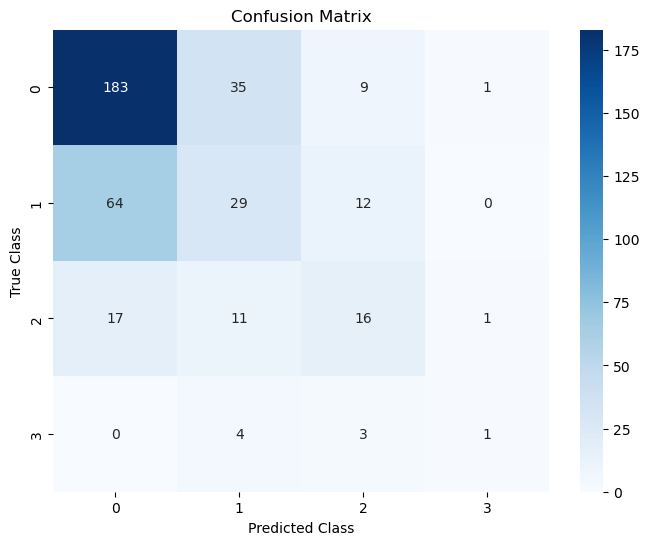

In [5]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns




X = train_data_cleaned.drop(columns=['sii', 'id'], errors='ignore')  
y = train_data_cleaned['sii']  


categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    X[col] = X[col].astype('category')


X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_clf, X_val_clf, y_train_clf, y_val_clf = X_train_reg, X_val_reg, y_train_reg, y_val_reg


y_train_clf = y_train_clf.astype(int)
y_val_clf = y_val_clf.astype(int)


xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    enable_categorical=True,
    random_state=42,
)
xgb_reg.fit(X_train_reg, y_train_reg)


y_pred_reg = xgb_reg.predict(X_val_reg)


mse = mean_squared_error(y_val_reg, y_pred_reg)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_reg, y_pred_reg)
r2 = r2_score(y_val_reg, y_pred_reg)

print("Regression Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


num_classes = y.nunique()
xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    n_estimators=100,
    enable_categorical=True,
    use_label_encoder=False,
    random_state=42,
)
xgb_clf.fit(X_train_clf, y_train_clf)


y_pred_clf = xgb_clf.predict(X_val_clf)


accuracy = accuracy_score(y_val_clf, y_pred_clf)
print("\nClassification Model Performance:")
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_val_clf, y_pred_clf))


conf_matrix = confusion_matrix(y_val_clf, y_pred_clf)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=range(num_classes),
    yticklabels=range(num_classes),
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


In [15]:
from sklearn.metrics import cohen_kappa_score
import numpy as np


true_labels_kappa = y_val_clf  
predicted_labels_kappa = y_pred_clf



weighted_kappa = cohen_kappa_score(true_labels_kappa, predicted_labels_kappa, weights='quadratic')

print(f"Weighted Kappa (Quadratic): {weighted_kappa:.4f}")


Weighted Kappa (Quadratic): 0.4102



Regression Model (as Classification) Performance:
Accuracy: 0.5881

Regression Model Confusion Matrix:


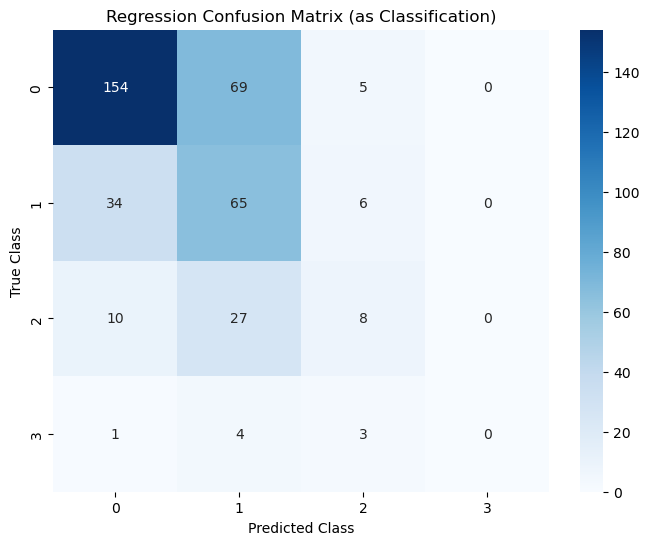

In [8]:

bins = np.arange(-0.5, 4.5, 1)  
y_pred_reg_class = np.digitize(y_pred_reg, bins) - 1  


accuracy_reg = accuracy_score(y_val_reg, y_pred_reg_class)
print("\nRegression Model (as Classification) Performance:")
print(f"Accuracy: {accuracy_reg:.4f}")

print("\nRegression Model Confusion Matrix:")
conf_matrix_reg = confusion_matrix(y_val_reg, y_pred_reg_class)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_reg,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=range(4),
    yticklabels=range(4),
)
plt.title("Regression Confusion Matrix (as Classification)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


In [10]:
import numpy as np


conf_matrix = np.array([
    [154, 69,  5,  0],
    [ 34, 65,  6,  0],
    [ 10, 27,  8,  0],
    [  1,  4,  3,  0]
])


true_positives = np.diag(conf_matrix)
false_positives = np.sum(conf_matrix, axis=0) - true_positives
false_negatives = np.sum(conf_matrix, axis=1) - true_positives
true_negatives = np.sum(conf_matrix) - (true_positives + false_positives + false_negatives)


precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)


accuracy = np.sum(true_positives) / np.sum(conf_matrix)


support = np.sum(conf_matrix, axis=1)
weighted_precision = np.sum(precision * support) / np.sum(support)
weighted_recall = np.sum(recall * support) / np.sum(support)
weighted_f1 = np.sum(f1_score * support) / np.sum(support)


print("Per-Class Metrics:")
for i, (p, r, f, s) in enumerate(zip(precision, recall, f1_score, support)):
    print(f"Class {i}: Precision={p:.4f}, Recall={r:.4f}, F1-Score={f:.4f}, Support={s}")

print("\nOverall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")


Per-Class Metrics:
Class 0: Precision=0.7739, Recall=0.6754, F1-Score=0.7213, Support=228
Class 1: Precision=0.3939, Recall=0.6190, F1-Score=0.4815, Support=105
Class 2: Precision=0.3636, Recall=0.1778, F1-Score=0.2388, Support=45
Class 3: Precision=nan, Recall=0.0000, F1-Score=nan, Support=8

Overall Metrics:
Accuracy: 0.5881
Weighted Precision: nan
Weighted Recall: 0.5881
Weighted F1-Score: nan


C:\Users\shaun\AppData\Local\Temp\ipykernel_6728\2432366794.py:18: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)


In [14]:
from sklearn.metrics import cohen_kappa_score
import numpy as np


true_labels_kappa = y_val_reg  
predicted_labels_kappa = y_pred_reg


bins = np.arange(-0.5, 4.5, 1)  
predicted_labels_binned = np.digitize(predicted_labels_kappa, bins) - 1  


weighted_kappa = cohen_kappa_score(true_labels_kappa, predicted_labels_binned, weights='quadratic')

print(f"Weighted Kappa (Quadratic): {weighted_kappa:.4f}")


Weighted Kappa (Quadratic): 0.3992
